In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')
# Hacky way to import module, sort out later by creating a package
import sys, os
sys.path.append(os.path.abspath('src/'))
from mc_agent import MonteCarlo, parse_arguments

In [2]:
env = gym.make('Blackjack-v0')
args = parse_arguments().parse_args(["--e", "Blackjack-v0", "--m", "../assets/Monte_Carlo/Blackjack_arrays.pkl"])
agent = MonteCarlo(env, args)
print(f'{len(agent.Q_store.state_map)} states encountered')

280 states encountered


In [3]:
data=[]
for (curr_sum, dealer_sum, usable_ace), idx in agent.Q_store.state_map.items():
    q_value = agent.Q_store.Q_values[idx]
    data.append((curr_sum, dealer_sum, usable_ace, q_value[0], q_value[1], q_value.max(), q_value.argmax()))
MC_data = pd.DataFrame(data, columns=['current_sum', 'dealer_card', 'usable_ace', 'q_value_0', 'q_value_1', 'VF', 'action'])
MC_data.head()

,current_sum,dealer_card,usable_ace,q_value_0,q_value_1,VF,action
0,11,9,False,-0.666667,-0.068699,-0.068699,1
1,17,9,False,-0.578947,-0.451163,-0.451163,1
2,20,10,False,0.376206,-0.847414,0.376206,0
3,15,10,False,-0.532258,-0.721940,-0.532258,0
4,18,10,False,-0.215789,-0.777778,-0.215789,0


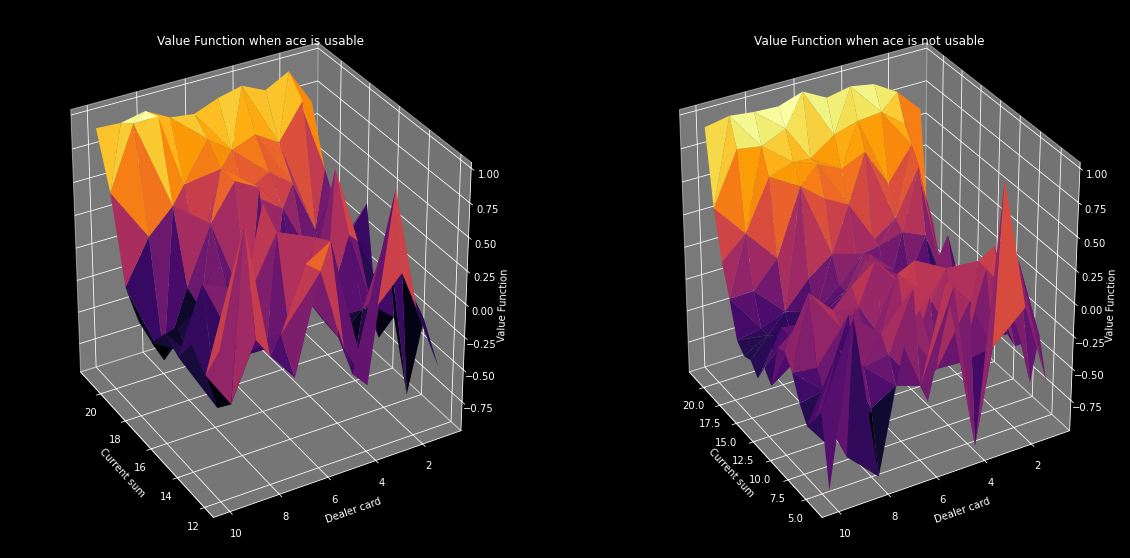

In [4]:
df = MC_data.loc[MC_data.usable_ace]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(azim=150)
ax.plot_trisurf(df['current_sum'], df['dealer_card'], df['VF'], cmap=plt.cm.inferno, linewidth=0.2)
ax.set_xlabel('Current sum')
ax.set_ylabel('Dealer card')
ax.set_zlabel('Value Function')
ax.set_title('Value Function when ace is usable')


df = MC_data.loc[~MC_data.usable_ace]
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(azim=150)
ax.plot_trisurf(df['current_sum'], df['dealer_card'], df['VF'], cmap=plt.cm.inferno, linewidth=0.2)
ax.set_xlabel('Current sum')
ax.set_ylabel('Dealer card')
ax.set_zlabel('Value Function')
ax.set_title('Value Function when ace is not usable')
plt.show()

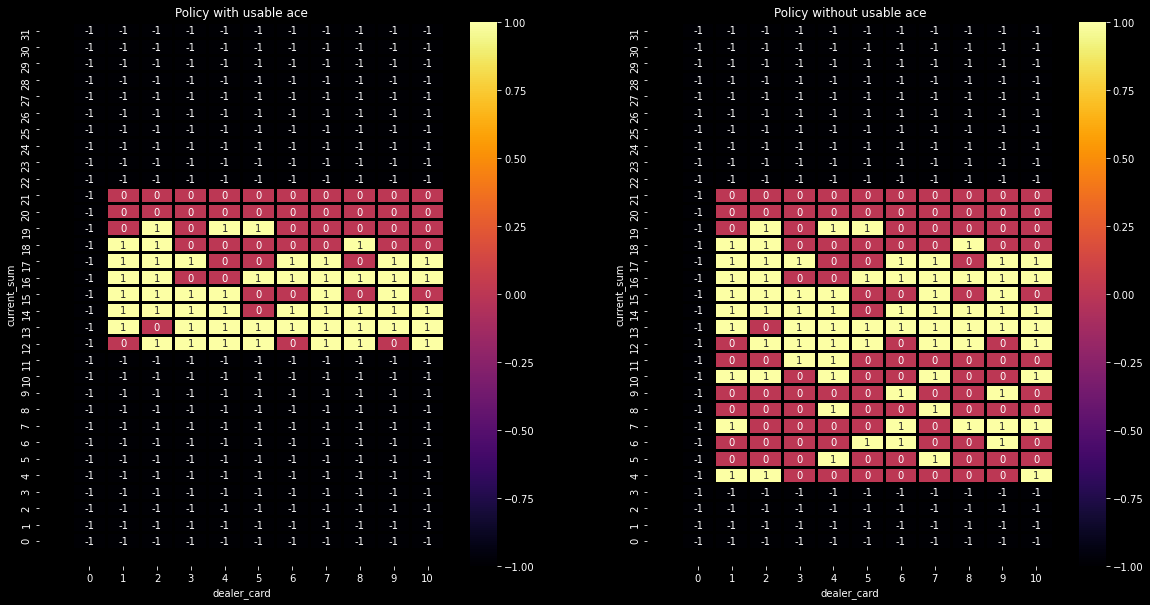

In [5]:
possible_current_sum, possible_dealer_card = 32, 11
grid_data = []
for current_sum in range(possible_current_sum):
    for dealer_card in range(possible_dealer_card):
        if (current_sum, dealer_card, True) in agent.Q_store.state_map:
            usable_ace_action = np.argmax(agent.Q_store.Q_values[agent.Q_store.get_index((current_sum, dealer_card, True)), :])
        else:
            usable_ace_action = -1

        if (current_sum, dealer_card, False) in agent.Q_store.state_map:
            not_usable_ace_action = np.argmax(agent.Q_store.Q_values[agent.Q_store.get_index((current_sum, dealer_card, True)), :])
        else:
            not_usable_ace_action = -1
        grid_data.extend([(current_sum, dealer_card, True, usable_ace_action) , (current_sum, dealer_card, False, not_usable_ace_action)])

df = pd.DataFrame(grid_data, columns=['current_sum', 'dealer_card', 'usable_ace', 'action'])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(df.loc[df.usable_ace][['current_sum', 'dealer_card', 'action']].pivot('current_sum', 'dealer_card', 'action'), \
            vmin=-1, vmax=1,cmap='inferno',annot=True,linecolor='k',linewidth=2)
plt.ylim(-1, 32)
plt.xlim(-1, 11)
plt.title('Policy with usable ace')

plt.subplot(1,2,2)
sns.heatmap(df.loc[~df.usable_ace][['current_sum', 'dealer_card', 'action']].pivot('current_sum', 'dealer_card', 'action'), \
            vmin=-1, vmax=1,cmap='inferno',annot=True,linecolor='k',linewidth=2)
plt.ylim(-1, 32)
plt.xlim(-1, 11)
plt.title('Policy without usable ace')
plt.show()